In [1]:
import os, sys
sys.path.insert(0, '/net/dali/home/mscbio/jih323/foldingdiff_seq/foldingdiff')

In [2]:
from foldingdiff import datasets
from foldingdiff import modelling
from foldingdiff import beta_schedules

/net/dali/home/mscbio/jih323/miniconda3/envs/foldingdiff/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
## model dir
# model_res_dir ="./results_2/"
model_res_dir ="./results_model1/"
Cache_name="./foldingdiff/cache_canonical_structures_cath_83a14642fa5c514f3bc80c553b5c801e.pkl"

In [4]:
import json
## read training configs
params = {}
with open(os.path.join(model_res_dir, 'training_args.json'), 'r') as f:
    model_params = json.load(f)
params.update(model_params)

In [5]:
from typing import *
import numpy as np

ANGLES_DEFINITIONS = Literal[
    "canonical" , "canonical-full-angles", "canonical-minimal-angles", "cart-coords"
]

def get_test_dsets(dataset_key: str = "cath",
    angles_definitions: ANGLES_DEFINITIONS = "canonical-full-angles",
    max_seq_len: int = 512,
    min_seq_len: int = 0,
    seq_trim_strategy: datasets.TRIM_STRATEGIES = "leftalign",
    timesteps: int = 250,
    variance_schedule: beta_schedules.SCHEDULES = "linear",
    var_scale: float = np.pi,
    exhaustive_t: bool = False,
    splits="test",
    cache_fn=""
):
    
    clean_dset = datasets.CathCanonicalAnglesSequenceDataset(
            pdbs=dataset_key,
            split=splits,
            pad=max_seq_len,
            min_length=min_seq_len,
            trim_strategy=seq_trim_strategy,
            zero_center=False if angles_definitions == "cart-coords" else True,
            use_cache=True,
            cache_fn=cache_fn
        )
    
    noised_dsets = datasets.NoisedAnglesDataset(
            dset=clean_dset,
            # dset_key="coords" if angles_definitions == "cart-coords" else "angles",
            dset_key="coords" if angles_definitions == "cart-coords" else ["angles","sequence"],    ## load both angles and sequence
            timesteps=timesteps,
            exhaustive_t=exhaustive_t,
            beta_schedule=variance_schedule,
            nonangular_variance=1.0,
            angular_variance=var_scale,
        )

    for dsname, ds in zip([splits], [noised_dsets]):
        print(f"{dsname}: {ds}")
    
    return noised_dsets


In [6]:
dsets = get_test_dsets(
        dataset_key=params['dataset_key'],
        angles_definitions=params['angles_definitions'],
        max_seq_len=params['max_seq_len'],
        min_seq_len=params['min_seq_len'],
        seq_trim_strategy=params['trim_strategy'],
        # seq_trim_strategy='discard',
        timesteps=params['timesteps'],
        variance_schedule=params['variance_schedule'],
        var_scale=params['variance_scale'],
        exhaustive_t=params["exhaustive_validation_t"],
        splits="test",
        cache_fn=Cache_name
    )

Using cache file ./foldingdiff/cache_canonical_structures_cath_83a14642fa5c514f3bc80c553b5c801e.pkl


test: NoisedAnglesDataset wrapping <foldingdiff.datasets.CathCanonicalAnglesSequenceDataset object at 0x7fc4d4094460> with 3210 examples with cosine-1000 with variance scales 1.0 and 1.0


In [17]:
import torch
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

def test_model(dset, model, device):
    # if torch.cuda.is_available():
    #     effective_batch_size = int(batch_size / torch.cuda.device_count())
    test_dataloader = DataLoader(
            dataset=dset,
            batch_size = params['batch_size'],
            shuffle=False,  # Shuffle only train loader
            num_workers=1,
            pin_memory=True,
        )
    '''
    batch:
    angles torch.Size([64, 128, 6])
    coords torch.Size([64, 128, 3])
    sequence torch.Size([64, 128])
    attn_mask torch.Size([64, 128])
    position_ids torch.Size([64, 128])
    lengths torch.Size([64])
    corrupted torch.Size([64, 128, 7])
    t torch.Size([64, 1])
    known_noise torch.Size([64, 128, 7])
    sqrt_alphas_cumprod_t torch.Size([64])
    sqrt_one_minus_alphas_cumprod_t torch.Size([64])
    '''
    input_seqs = []
    denoised_values = []

    for batch in tqdm(test_dataloader):
        predicted_noise = model(
            batch["corrupted"].to(device),
            batch["t"].to(device),
            attention_mask=batch["attn_mask"].to(device),
            position_ids=batch["position_ids"].to(device),
        ).detach().cpu()
        bs = batch["sqrt_one_minus_alphas_cumprod_t"].shape[0]
        denoised_angles = (
            batch["corrupted"]
            - batch["sqrt_one_minus_alphas_cumprod_t"].view(bs, 1, 1)
            * predicted_noise
        )
        denoised_angles /= batch["sqrt_alphas_cumprod_t"].view(bs, 1, 1)
        # denoised_values.append(denoised_angles[:,:,6])
        denoised_values.extend([denoised_angles[i,:,6][batch["attn_mask"][i].bool()] for i in range(bs)])
        # input_seqs.append(batch['sequence'][batch["attn_mask"].bool()])
        input_seqs.extend([batch['sequence'][i][batch["attn_mask"][i].bool()] for i in range(bs)])
    
    # return torch.cat(denoised_values), torch.cat(input_seqs)
    return denoised_values, input_seqs
        


In [18]:
device=torch.device("cuda:1")
model = modelling.BertForDiffusionBase.from_dir(
    model_res_dir
).to(device)

Using time embedding: GaussianFourierProjection()


In [9]:
model

BertForDiffusionBase(
  (inputs_to_hidden_dim): Linear(in_features=7, out_features=512, bias=True)
  (embeddings): BertEmbeddings(
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (distance_embedding): Embedding(255, 32)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
 

In [19]:
denoised_values, input_seqs = test_model(dsets, model=model, device=device)
# input_seqs = test_model(dsets, model=model)

100%|██████████| 51/51 [00:10<00:00,  4.73it/s]


In [21]:
denoised_values[0][:10]

tensor([-1.2751, -0.5176, -2.8245,  0.5538,  2.6222, -1.4976,  2.6102, -2.2824,
        -0.1829, -2.0967])

In [22]:
input_seqs[0][:10]

tensor([ 0.1571,  0.1571, -2.9845,  0.1571,  2.6704, -1.0996,  1.7279, -2.6704,
        -0.4712, -2.0420])

In [23]:
seq_order = ['T', 'S', 'A', 'G', 'P', 'R', 'K', 'N', 'D', 'E', 'Q', 'H', 'Y', 'W', 'F', 'L', 'M', 'I', 'V', 'C']
seq2angle = {aa:angle for aa, angle in zip(seq_order, (np.linspace(-np.pi, np.pi, 20, endpoint=False)+np.pi/20))}
angle2seq = {angle:aa for aa, angle in seq2angle.items()}

In [24]:
def classify_aa(preds: torch.Tensor, angle2seq: dict) -> list:
    label_keys = torch.tensor(list(angle2seq.keys()))  # tensor of label keys
    assigned_labels = []
    
    for v in preds:
        distances = torch.abs(label_keys - v)  # find absolute distance to each label
        closest_idx = torch.argmin(distances)  # find the index of the closest label
        closest_label = angle2seq[label_keys[closest_idx].item()]  # retrieve label
        assigned_labels.append(closest_label)
    
    return assigned_labels

In [25]:
print(classify_aa(denoised_values[0][:10], angle2seq))
print(classify_aa(input_seqs[0][:10], angle2seq))

['R', 'D', 'S', 'H', 'V', 'R', 'V', 'A', 'E', 'G']
['Q', 'Q', 'T', 'Q', 'V', 'K', 'L', 'S', 'D', 'G']


In [26]:
def seq_pred_acc(input_seqs, denoised_values):
    # bs = input_seqs.shape[0]
    bs = len(input_seqs)
    acc_all = []
    for i in range(bs):
        labels_input = classify_aa(input_seqs[i], angle2seq)
        labels_output = classify_aa(denoised_values[i], angle2seq)
        acc = sum(a == b for a, b in zip(labels_input, labels_output))/input_seqs[i].shape[-1]
        acc_all.append(acc)
    return acc_all

In [27]:
acc_all = seq_pred_acc(input_seqs, denoised_values)

In [32]:
acc_all

[0.2734375,
 0.09166666666666666,
 0.0546875,
 0.28125,
 0.5581395348837209,
 0.6,
 0.0945945945945946,
 0.2578125,
 0.2882882882882883,
 0.9765625,
 0.09375,
 0.011235955056179775,
 0.1640625,
 0.0625,
 0.09375,
 0.2734375,
 0.47619047619047616,
 0.2112676056338028,
 0.425531914893617,
 0.1953125,
 0.171875,
 0.09375,
 0.1015625,
 0.2653061224489796,
 0.2265625,
 0.10144927536231885,
 0.1875,
 0.08333333333333333,
 0.0821917808219178,
 0.125,
 0.265625,
 0.1328125,
 0.19827586206896552,
 0.1171875,
 0.0625,
 0.046875,
 0.9609375,
 0.16455696202531644,
 0.125,
 1.0,
 0.4945054945054945,
 0.07352941176470588,
 0.25961538461538464,
 0.0390625,
 0.5390625,
 0.2734375,
 0.1796875,
 1.0,
 0.0546875,
 0.0390625,
 0.18253968253968253,
 0.2109375,
 0.1,
 0.0375,
 0.5377358490566038,
 0.0625,
 0.06349206349206349,
 0.1484375,
 0.0761904761904762,
 0.18032786885245902,
 0.1111111111111111,
 0.15625,
 0.14285714285714285,
 0.2542372881355932,
 0.1328125,
 0.3359375,
 0.015625,
 0.296875,
 1.0,
 0

In [35]:
np.mean(acc_all)

0.28819297196876775

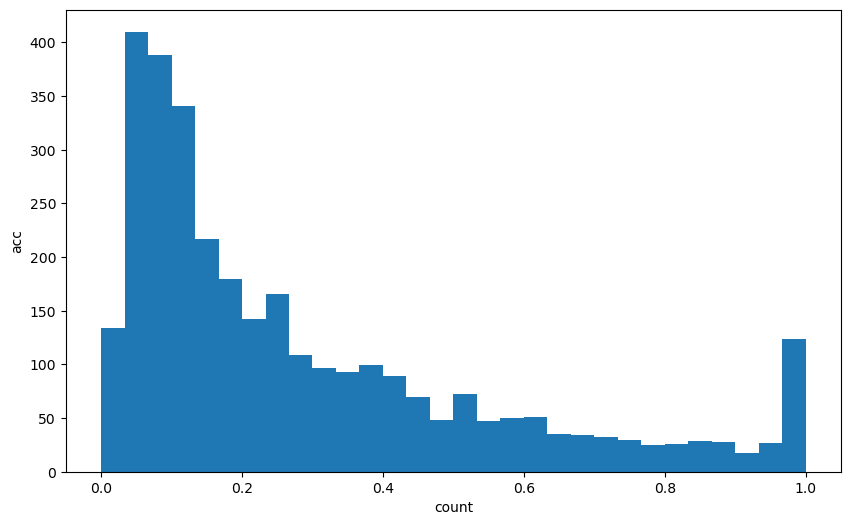

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(acc_all, bins=30)
plt.xlabel('count')
plt.ylabel('acc')
plt.show()